<a href="https://colab.research.google.com/github/mbarte/AMD/blob/main/GCCategorical_Framework_AMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GALAXY CLASSIFICATION TASK - CLASSIFICATION**
**RUN W/ CPU, HIGH RAM**


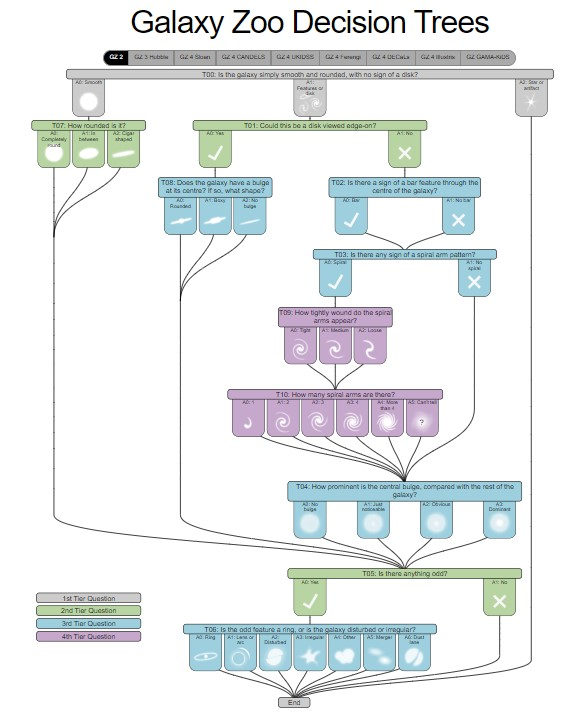


Credits:

https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/

https://data.galaxyzoo.org/gz_trees/gz_trees.html

This project comes from a personal rapidly increasing interest in the astronomic field. The main goal is to apply the fundamental DeepLearning techniques to this matter, while coming up with an innovative framework which departs from regression.

The data comes from an exciting mission called GalaxyZoo every single person can contribute to: https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


Since the great amount of data available, it is reccomended to use a high-RAM runtime

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Import the necessary libraries

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import os
import copy
import time
import itertools
import h5py

from sklearn.preprocessing import LabelEncoder, StandardScaler

import PIL #import pillow 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers, metrics, losses, callbacks, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

In [ ]:
strategy = tf.distribute.get_strategy()
strategy

# Fully automatic import [Run this to download and unzip the dataset]

In [ ]:
os.environ['KAGGLE_USERNAME'] = "michelebarte" 
os.environ['KAGGLE_KEY'] = "85bdd7673d63f1cd611f2e4cab0e1f6e" 

#Download
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

print("Downloading done!")

100% 1.77G/1.77G [01:00<00:00, 29.1MB/s]
100% 1.77G/1.77G [01:00<00:00, 31.4MB/s]


In [ ]:
#Unzip
start = time.time()

!unzip /content/galaxy-zoo-the-galaxy-challenge.zip                             #-d /content/<folder name> to create a specific folder 

end = time.time()
print("Unzipping done!")
print("The process took {:.2f} hours.".format((end - start)/3600))

Archive:  /content/galaxy-zoo-the-galaxy-challenge.zip
  inflating: all_ones_benchmark.zip  
  inflating: all_zeros_benchmark.zip  
  inflating: central_pixel_benchmark.zip  
  inflating: images_test_rev1.zip    
  inflating: images_training_rev1.zip  
  inflating: training_solutions_rev1.zip  
Unzipping done!
The process took 0.01 hours.


In [ ]:
%%capture                                                                       
#suppress the "inflating filename..." output

start = time.time()

!unzip /content/images_training_rev1.zip                                        #unzip training data
!unzip /content/images_test_rev1.zip                                            #unzip testing data
!unzip /content/training_solutions_rev1.zip                                     #unzip training labels

end = time.time()

print("Unzipping done!")
print("The process took {:.2f} hours.".format((end - start)/3600))

# Functions

In [ ]:
BATCH_SIZE = 128                                                            
#The batch size can be made smaller so that the model will do less coarse steps in order to look for the optimal solution and is more likely to converge to it
#For computational reasons we use a larger one

AUTOTUNE = tf.data.AUTOTUNE                                                     #efficiency reason

- Utility CallBack for plotting curves (credits to https://github.com/dhodun)

In [ ]:
from IPython.display import clear_output
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)

- Functions to explore the available images in the folder

In [ ]:
def resolution(files_list, num):
  '''
  prints the size of the first num images in the folder
  '''
  for file in range(num):
    image = PIL.Image.open(files_list[file])
    print("The images size is", image.width, "x", image.height)

def display10(files_list, nrows, ncols):
  '''
  Display the first nrows*ncols images in the folder
  '''
  rows = nrows
  columns = ncols
  images = list()

  fig = plt.figure(figsize= (15,15))
  position = 1
  for file in range(0,nrows*ncols):
    images.append(mpimg.imread(files_list[file]))
    fig.add_subplot(rows, columns, position)
    plt.imshow(images[file])
    plt.axis('off')
    plt.tight_layout()
    position +=1

- Function to turn to categorical framework

In [ ]:
def to_cat(labels):
  '''
  takes the labels as an input and convert the dataframe into a dictionary containing 26 classes for a categorical classification problem
  '''
  lb = labels.iloc[:,1:]   #values only
  id = labels.iloc[:,0]    #id's only

  class1 = lb.iloc[:,0:3]
  class2 = lb.iloc[:,3:5]
  class3 = lb.iloc[:,5:7]
  class4 = lb.iloc[:,7:9]
  class5 = lb.iloc[:,9:13]
  class6 = lb.iloc[:,13:15]
  class7 = lb.iloc[:,15:18]
  class8 = lb.iloc[:,18:25]
  class9 = lb.iloc[:,25:28]
  class10 = lb.iloc[:,28:31]
  class11 = lb.iloc[:,31:37]

  cat_labels = {}                                                             #dictionary storing galaxyID: categorical label
  #for i in labels["GalaxyID"]:
  for i in range(len(labels)):
    #---------------------------------------------------------------------------
    if class1.iloc[i].idxmax() == "Class1.3":  #se non è nè tonda nè a spirale
      cat_labels[id[i]] = "Other"   #non è una galassia
    #---------------------------------------------------------------------------
    elif class1.iloc[i].idxmax() == "Class1.1":    #se è smooth
      #-------------------------------------------------------------------------
      if class7.iloc[i].idxmax() == "Class7.1" or class7.iloc[i].idxmax() == "Class7.2":    # se perfettamente tonda o quasi
        if class6.iloc[i].idxmax() == "Class6.2":  #se non ha features aggiuntive
          cat_labels[id[i]] ="Elliptical"        

        elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.1":
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.2":
         cat_labels[id[i]]= "Other"
        elif class8.iloc[i].idxmax() == "Class8.3":
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.4":
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.5":
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.6":
          cat_labels[id[i]] = "Other"
      #-------------------------------------------------------------------------
      elif class7.iloc[i].idxmax() == "Class7.3":      #se è a forma di sigaro
        if class6.iloc[i].idxmax() == "Class6.2":   #se non ha features aggiuntive
          cat_labels[id[i]] = "Cigar shaped smooth"    #sigaro smooth

        elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.1":
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.2":
         cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.3":
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.4":
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.5":
          cat_labels[id[i]] = "Other"
        elif class8.iloc[i].idxmax() == "Class8.6":
          cat_labels[id[i]] = "Other"
  
    #---------------------------------------------------------------------------
    elif class1.iloc[i].idxmax() == "Class1.2":    #galassia, ma non smooth
      #-------------------------------------------------------------------------
      if class2.iloc[i].idxmax() == "Class2.1":    # se è edge on
          if class6.iloc[i].idxmax() == "Class6.2":   #se non ha features aggiuntive
            cat_labels[id[i]] = "Disc edge on"    

          elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.1":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.2":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.3":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.4":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.5":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.6":
            cat_labels[id[i]] = "Other"
      #-------------------------------------------------------------------------
      if class2.iloc[i].idxmax() == "Class2.2":    # se non è edge on
        #-----------------------------------------------------------------------
        if class4.iloc[i].idxmax() == "Class4.2":  #se non ha bracci
            if class6.iloc[i].idxmax() == "Class6.2":   #se non ha features aggiuntive
              cat_labels[id[i]] = "Elliptical"     #disc edge on

            elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.1":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.2":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.3":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.4":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.5":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.6":
              cat_labels[id[i]] = "Other"
        #-----------------------------------------------------------------------    
        elif class4.iloc[i].idxmax() == "Class4.1":  #se ha bracci
          #---------------------------------------------------------------------
          if class10.iloc[i].idxmax() == "Class10.1":  #se tight
            if class6.iloc[i].idxmax() == "Class6.2":   #se non ha features aggiuntive
              cat_labels[id[i]] = "Tight Spiral "    

            elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.1":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.2":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.3":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.4":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.5":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.6":
              cat_labels[id[i]] = "Other"
          #---------------------------------------------------------------------
          elif class10.iloc[i].idxmax() == "Class10.2":  #se medium
              if class6.iloc[i].idxmax() == "Class6.2":   #se non ha features aggiuntive
                cat_labels[id[i]] = "Medium Spiral"    

              elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.1":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.2":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.3":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.4":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.5":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.6":
                cat_labels[id[i]] = "Other"   
          #---------------------------------------------------------------------    
          elif class10.iloc[i].idxmax() == "Class10.3":  #se loose
              if class6.iloc[i].idxmax() == "Class6.2":   #se non ha features aggiuntive
                cat_labels[id[i]] = "Loose Spiral"     

              elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.1":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.2":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.3":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.4":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.5":
                cat_labels[id[i]] = "Other"
              elif class8.iloc[i].idxmax() == "Class8.6":
                cat_labels[id[i]] = "Other"
              
  return cat_labels

#TODO: Future work: re-write this function in an efficient way

- Function for plotting images with their categorical label

In [ ]:
def displaycat(files_list, nrows, ncols):
  '''
  Display the first nrows*ncols images in the folder with labels
  '''
  rows = nrows
  columns = ncols
  images = dict()

  fig = plt.figure(figsize = (15,15))
  position = 0
  for file in range(0,nrows*ncols):
    if position < nrows * ncols:
      position +=1 
    filename = files_list[file]
    id = int(tf.strings.substr(filename, 0, tf.strings.length(filename)-4))     #remove extension and convert to integer
    row = categorical_data.loc[categorical_data["GalaxyID"] == id]              #access the corresponding row in the categorical_data dataframe
    label = row.iloc[0,0]                                                       #save the label
    
    path = "/content/images_training_rev1/"
    images[id] = mpimg.imread(path + files_list[file])                          #add the image to the dictionary with key=GalaxyID and value = the image
    fig.add_subplot(rows, columns, position)
    plt.title(label)                                                            #Print the corresponding label as a title   
    plt.imshow(images[id])                                                      #show the image for the current ID
    
    plt.axis('off')
    plt.tight_layout()

- Functions to create the datasets, making use of tensorflow pipelines for efficiency

In [ ]:
#Same functions, with subtle differences, to prepare the dataset
def image_cat_preparation(img):
  '''
  Takes the path of the image and encode it as a Tensor, resizing it to exclude other galaxies
  '''
  image = tf.io.decode_image(tf.io.read_file(img), dtype=tf.dtypes.float32)     
  image = tf.image.resize_with_crop_or_pad(image, 150,150)
  image = tf.image.resize(image, [50,50])
  image = tf.image.per_image_standardization(image)
 
  return image
#-------------------------------------------------------------------------------
def training_cat_preparation(img):    #try
  '''
  input: file (image)
  returns image associated with its label
  '''
  path = "/content/images_training_rev1/"
  image = image_cat_preparation(path + img)
  id = int(tf.strings.substr(img, 0, tf.strings.length(img)-4))                 #remove .jpg and convert to integer to allow comparison
  row = final.loc[final["GalaxyID"] == id]                                      #retrieve the corresponding row in the labels dataframe
  lbl = tf.cast(row.iloc[0,:7].values, tf.float32) #tf.uint8
                    
  return image, lbl

def compile_cat_training(images_path):
  images_path_ds = tf.data.Dataset.from_tensor_slices(images_path)
  dataset = images_path_ds.map(lambda x: tf.py_function(func=training_cat_preparation, inp=[x], Tout=(tf.float32,tf.float32)), num_parallel_calls=AUTOTUNE) #tf.uint8
  
  dataset = dataset.cache()      
  
  dataset = dataset.shuffle(len(dataset), reshuffle_each_iteration = True)      #common practice to increase the power of generalisation
  
  dataset = dataset.batch(BATCH_SIZE) 
  
  dataset = dataset.prefetch(AUTOTUNE)                                          #Reduce read latency while training the model (the next batch is fetched while training on the current one)
  return dataset


def compile_cat_validation(images_path, validation = True):
  images_path_ds = tf.data.Dataset.from_tensor_slices(images_path)
  dataset = images_path_ds.map(lambda x: tf.py_function(func=training_cat_preparation, inp=[x], Tout=(tf.float32,tf.float32)), num_parallel_calls=AUTOTUNE) #tf.uint8
  
  dataset = dataset.cache()  
 
  dataset = dataset.batch(BATCH_SIZE)                                         #we use the dataset in the .fit() method, therefore we need compatibel dimensions (batch, 100, 100, 3)
    
  return dataset

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
def test_cat_preparation(img):
  '''
  input: file (image)
  returns image associated with its label
  '''
  image = image_cat_preparation(img)
  return image

def compile_cat_test(images_path):
  images_path_ds = tf.data.Dataset.from_tensor_slices(images_path)
  dataset = images_path_ds.map(lambda x: tf.py_function(func=test_cat_preparation, inp=[x], Tout=(tf.float32,tf.float32)), num_parallel_calls=AUTOTUNE) #tf.uint8

  dataset = dataset.cache()  

  dataset = dataset.batch(BATCH_SIZE)    
  
  return dataset      

- Function to take a look at the images in the dataset 

In [ ]:
#Take a look at the images the way they are used to train the model
def plot_example(dataset, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    images = list(dataset.take(1).as_numpy_iterator())[0][0]
    labels = list(dataset.take(1).as_numpy_iterator())[0][1]
    for i in range(rows):
        for j in range(cols):
            axes[i,j].grid(False)
            axes[i,j].axis('off')
            axes[i,j].imshow(images[cols*i+j, :])
    plt.show()
    return images[0].shape, labels[0].shape

- Functions to build the CNN models

In [ ]:
def tiny_vgg(input_shape):
  model = tf.keras.Sequential(name = "TinyVGG")

  model.add(layers.InputLayer(input_shape=input_shape))
  model.add(Conv2D(filters = 64, kernel_size =(3,3), padding = "valid", activation = "relu"))
  model.add(Conv2D(filters = 64, kernel_size =(3,3), padding = "valid", activation = "relu"))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "valid", activation = "relu"))
  model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "valid", activation = "relu"))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = "valid", activation = "relu"))
  model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = "valid", activation = "relu"))
  model.add(layers.Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(7, activation = "softmax"))

  return model
  #the galaxy occupies all the 64x64 pixels now, so we want to use padding not to loose too much information

In [ ]:
def cnn(input_shape):
    model = tf.keras.models.Sequential(name="Regression_Model", layers=[
        layers.Conv2D(filters=16,kernel_size=(3, 3), padding = "valid", activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=32,kernel_size=(5, 5), padding = "valid", activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=64,kernel_size=(3, 3), padding = "valid",activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=128,kernel_size=(3, 3), padding = "valid",activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(7, activation='softmax')
    ])

    return model

- A function to tackle the class imbalance problem

In [ ]:
#credits: https://gist.github.com/wassname
## Tensorflow/Keras
#def weighted_categorical_crossentropy(weights):
#    """
#    A weighted version of keras.objectives.categorical_crossentropy
#   
#    weights: numpy array of shape (C,) where C is the number of classes
#             np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
#    """
#    weights = K.variable(weights)
#        
#    def loss(y_true, y_pred, from_logits=False):
#      if from_logits:
#		      y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
#          #y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
#      # clip to prevent NaN's and Inf's
#      y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#      # calc
#      loss = y_true * K.log(y_pred) * weights
#      loss = -K.sum(loss, -1)
#      return loss
#    
#    return loss

- Function to schedule the learning rate decrease

In [ ]:
def decay_schedule(epoch, lr):
    return lr * 0.8 if (epoch % 4 == 0) and (epoch != 0) else lr

# Preprocessing

In [ ]:
# Retrieve the list of files in the foldes
files_list = tf.io.gfile.glob("/content/images_training_rev1/*")
print("The total number of files is: ", len(files_list))

The total number of files is:  61578


The images size is 424 x 424
These are the first 10 images:


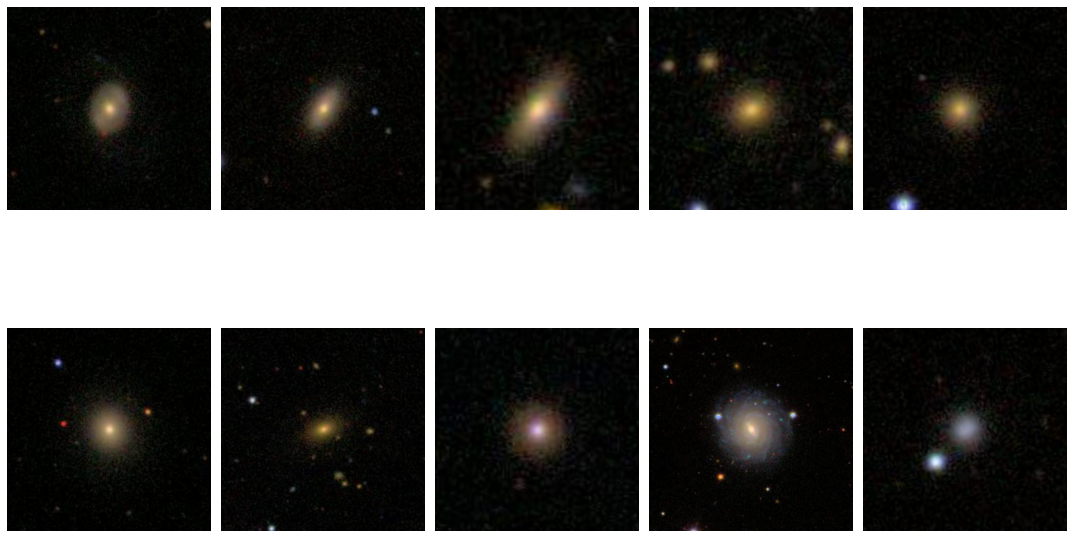

In [ ]:
#All the images are 424x424
resolution(files_list, 1)
print("These are the first 10 images:")
display10(files_list, 2, 5)  #display the first images

Using such dimensions would require more computational power and more time to train the models. Moreover, we are solely interested in the centre of the image (to avoid having multiple galaxies in within the same picture, thing that would make the task more difficult).

In [ ]:
#Observe again the labels we have
labels = pd.read_csv("/content/training_solutions_rev1.zip")
print("The shape of the dataframe is: ", labels.shape)
labels.head()

The shape of the dataframe is:  (61578, 38)


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


The original problem was basically a regression task rather than a classification. In fact, each image has a label which is a vector of probabilities. Each entry is the probability of answering yes to the one of the nodes of the decision tree at the beginning of this notebook.

To give an insight into the classes, what follows is a short textual explanation

- Class 1 (Shape):
  - .1: Smooth, .2: Features or disk, .3: Star or artifact

- Class 2 (Disk-like):
  - .1: Disk viewed edge-on, .2: No 

- Class 3 (Bar through the centre):
  - .1: Bar, .2: No bar

- Class 4 (Spiral):
  - .1: Spiral, .2: No spiral

- Class 5 (Bulge):
 - .1: No bulge, .2: Just noticeable, .3: Obvious, .4: Dominant

- Class 6 (Anything odd):
  - .1: Yes, .2: No

- Class 8 (Odd feature):
  - .1: Ring, .2: Lens or arc, .3: Disturbed, .4: Irregular, .5: Other, .6: Merging, .7: Dust lane

- Class 7 (Roundness):
  - .1: Completely round, .2: In between ,.3: Cigar shaped

- Class 9 (Bulge shape):
  - .1: Rounded, .2: Boxy, .3: No Bulge

- Class 10 (Spiral arms)
  - .1: Tight, .2: Medium, .3: Loose

- Class 11 (Spiral arms number)
  - .1: 1, .2: 2, .3: 3, .4: 4, .5: More than 4, .6: Can't tell

Starting from the textual description provided above, I decided to create a custom function to transform the problem into a classification task, reducing the number of classes, also for interpretability purposes.

In [ ]:
#Convert into categorical labels (26 classes)
#cat_labels = to_categorical(labels)
cat_labels = to_cat(labels)

In [ ]:
example = dict(list(cat_labels.items())[0:5])                          #show the "first" 5 elements
print("Total number of classified galaxies: ", len(cat_labels))
example 

Total number of classified galaxies:  61514


{100008: 'Tight Spiral ',
 100023: 'Loose Spiral',
 100053: 'Elliptical',
 100078: 'Elliptical',
 100090: 'Elliptical'}

Observe that we lost a few galaxies due to the minor degree of precision while labelling them. However, "sacrificing" several classes only led to leaving 64 galaxies unlabeled, which is the 0,001% of the data.

Exploit the dictionary I created to create a new dataframe containing the labels for the images.

In [ ]:
#Create a dataframe from the dictionary
categorical_data = pd.DataFrame.from_dict(cat_labels, orient = "index", columns = ["LABEL"])

#Create a column containing the index, namely the GalaxyID and reset the index to count the rows
categorical_data["GalaxyID"] = categorical_data.index
categorical_data.reset_index(drop=True)
categorical_data.head()  

,LABEL,GalaxyID
100008,Tight Spiral,100008
100023,Loose Spiral,100023
100053,Elliptical,100053
100078,Elliptical,100078
100090,Elliptical,100090


In [ ]:
levels = list(np.unique(categorical_data["LABEL"]))    #8 unique classes
print("There are ", len(levels), " unique classes: ")
levels

There are  7  unique classes: 


['Cigar shaped smooth',
 'Disc edge on',
 'Elliptical',
 'Loose Spiral',
 'Medium Spiral',
 'Other',
 'Tight Spiral ']

Now we have to remove the unclassified galaxies from the files list, so that they won't be mistakenly considered by the model, thus leading to an error (since they cannot be found in the dataset containing the labels)

In [ ]:
#Create a list with the ID of the galaxies without categorical label
missing = []
for file in range(len(files_list)):
  filenum = tf.strings.split(files_list[file],  "/")[3]                                     
  id = int(tf.strings.substr(filenum, 0, tf.strings.length(filenum)-4))      
  if id not in categorical_data["GalaxyID"]:                                  
    missing.append(id)

print("The number of the galaxies without categorical label is the difference between the total number of files and the number of galaxies in categorical_data: ",
      len(missing) == len(files_list) - len(categorical_data))
missing[:10]

#TODO: make it more efficient

The number of the galaxies without categorical label is the difference between the total number of files and the number of galaxies in categorical_data:  True


[278909,
 559503,
 517233,
 767720,
 263699,
 585135,
 434808,
 115858,
 227080,
 530309]

In [ ]:
files_list = os.listdir("/content/images_training_rev1/")                       #easier to work with strings instead of Tensors in this case

In [ ]:
#retrieve the name of the file starting from the ID and delete it from the list of files that will be used to train and test the model
print("Total number of elements before: ", len(files_list))
for i in range(len(missing)):
  filename = str(missing[i]) + ".jpg"
  files_list.remove(filename)                                                   #os.remove() would work as well while still working with tensors instead of os.listdir
  print(filename, "removed successfully!")
print("Total number of elements after: ", len(files_list))

Total number of elements before:  61578
278909.jpg removed successfully!
559503.jpg removed successfully!
517233.jpg removed successfully!
767720.jpg removed successfully!
263699.jpg removed successfully!
585135.jpg removed successfully!
434808.jpg removed successfully!
115858.jpg removed successfully!
227080.jpg removed successfully!
530309.jpg removed successfully!
745835.jpg removed successfully!
274716.jpg removed successfully!
909146.jpg removed successfully!
338221.jpg removed successfully!
580861.jpg removed successfully!
317002.jpg removed successfully!
776725.jpg removed successfully!
696736.jpg removed successfully!
858082.jpg removed successfully!
299627.jpg removed successfully!
797040.jpg removed successfully!
214865.jpg removed successfully!
631021.jpg removed successfully!
966558.jpg removed successfully!
621930.jpg removed successfully!
513543.jpg removed successfully!
419034.jpg removed successfully!
774631.jpg removed successfully!
875848.jpg removed successfully!
655

We can take a better look at the images with their labels. Note that images are labelled by humans as part of the GalaxyZoo mission. Anyone can join the website and manually label images according to the decision tree

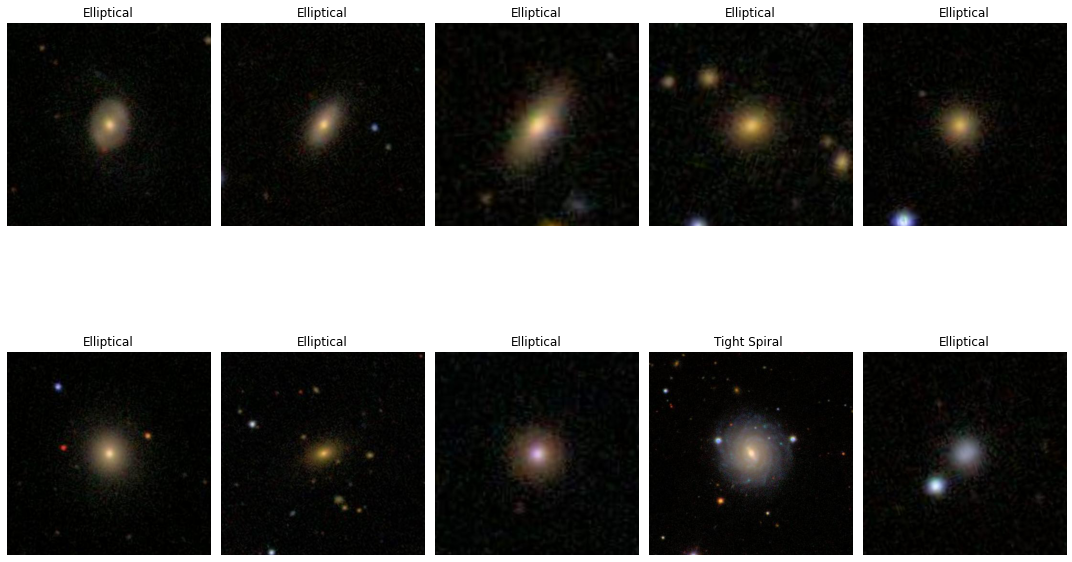

In [ ]:
displaycat(files_list, 2, 5)  #display the first images

In order to use the model we need to encode the strings into numbers. We could use two approaches:

- Encode the classes into integers: train a model with a single output node using SparseCategoricalCrossentroopy() as loss function and SparseCategoricalAccuracy() as accuracy metrics, computing how distant it the output from the actual integer label
________________________________________________________________________________
encoded_data = copy.deepcopy(categorical_data)                                  #create a copy in order not to modify categorical_data as well

etichette = categorical_data["LABEL"]
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(np.array(etichette))
integer_encoded
encoded_data["LABEL"] = integer_encoded
encoded_data.head()

________________________________________________________________________________
- Use OneHot Encoding and deploy CategoricalCrossentropy() as loss function, and CategoricalAccuracy() as accuracy metric.

I opted for the second case

In [ ]:
#Create the dummy variables
pd.set_option('display.max_columns', False)
one_hot = pd.get_dummies(categorical_data['LABEL'])
one_hot.head()

,Cigar shaped smooth,Disc edge on,Elliptical,Loose Spiral,Medium Spiral,Other,Tight Spiral
100008,0,0,0,0,0,0,1
100023,0,0,0,1,0,0,0
100053,0,0,1,0,0,0,0
100078,0,0,1,0,0,0,0
100090,0,0,1,0,0,0,0


In [ ]:
#Obtain the final dataset containing: GalaxyID and 26 columns corresponding to thge 26 classes and 0-1 entries to encode the class each galaxy belongs to
final = pd.merge(one_hot, categorical_data, left_index =  True, right_on = "GalaxyID")
final.drop(columns="LABEL", inplace = True)
final = final.reset_index(drop=True)
final.head()

,Cigar shaped smooth,Disc edge on,Elliptical,Loose Spiral,Medium Spiral,Other,Tight Spiral,GalaxyID
0,0,0,0,0,0,0,1,100008
1,0,0,0,1,0,0,0,100023
2,0,0,1,0,0,0,0,100053
3,0,0,1,0,0,0,0,100078
4,0,0,1,0,0,0,0,100090


We can create and split the dataset. Instead of splitting a tensor dataset (which is hard) we split the files list and compile the different sets. We have

Training set: to train the model
Validation set: to validate during training
Test set: to assess the power of generalisation of the model

In [ ]:
seed = 123
tf.random.set_seed(seed)
files_list = tf.random.shuffle(files_list)                                      #we also shuffle the files list
size = len(final)
print("Number of total samples: {}".format(size))
 
train_cat_index = int(np.floor(size*0.8))                                       #80% of data as training
remaining_cat = size - train_cat_index
test_cat_index = int(np.floor(remaining_cat*0.15))                             

files_train_cat = files_list[remaining_cat:]                                     
files_val_cat = files_list[test_cat_index:remaining_cat]                               
files_test_cat = files_list[:test_cat_index]                                      

train_cat = compile_cat_training(files_train_cat)                             
print("Training set batches: ",tf.data.experimental.cardinality(train_cat))
val_cat = compile_cat_validation(files_val_cat, validation = True)
print("Validation set batches: ", tf.data.experimental.cardinality(val_cat))
test_cat = compile_cat_validation(files_test_cat, validation = False)
print("Test set batches: ", tf.data.experimental.cardinality(test_cat))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Number of total samples: 61514
Training set batches:  tf.Tensor(385, shape=(), dtype=int64)
Validation set batches:  tf.Tensor(82, shape=(), dtype=int64)
Test set batches:  tf.Tensor(15, shape=(), dtype=int64)


Preprocessed images examples


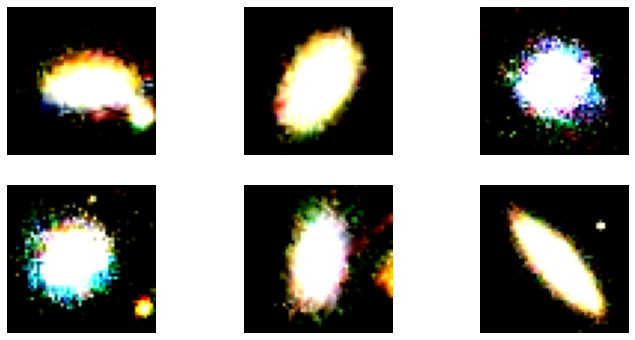

The images shape is: (50, 50, 3)
The features shape is: (7,)


In [ ]:
#Take a look at the images in the training dataset
print("Preprocessed images examples")
image_shape, features_num = plot_example(train_cat)
print("The images shape is: {}".format(image_shape))
print("The features shape is: {}".format(features_num))  

In [ ]:
counts = pd.DataFrame(categorical_data.groupby("LABEL").count())
counts.columns = ["count"]
counts["LABEL"] = counts.index
counts.reset_index(inplace = True, drop = True)
counts

,count,LABEL
0,1544,Cigar shaped smooth
1,6279,Disc edge on
2,32295,Elliptical
3,1344,Loose Spiral
4,5253,Medium Spiral
5,8458,Other
6,6341,Tight Spiral


In [ ]:
weights = []
for i in range(7):
  weights.append(len(categorical_data) /(7 * counts.iloc[i, 0]))
weights = np.array(weights)
weights

#class_weight not supported for more than 3 classes

array([5.6915248 , 1.39954042, 0.27210758, 6.53847789, 1.6728944 ,
       1.03898254, 1.38585622])

# VGG-LIKE Model

After having trained a model I created (which took approximately 10 hours to train and performed badly, I decided to opt for a much smaller architecture, but known to be well-performing)

At the end of this section one can find the images about the model I mentioned above, which I also saved on disk and could be loaded after training

In [ ]:
with strategy.scope(): 
  image_shape = (50,50,3)
  tiny_model = tiny_vgg(image_shape)
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1) # Optimizer
  loss_func = tf.keras.losses.CategoricalCrossentropy() # Loss function
  #loss_func = weighted_categorical_crossentropy(weights)
  tiny_model.compile(loss=loss_func, optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy()]) 


tiny_model.summary()

Model: "TinyVGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_142 (Conv2D)         (None, 48, 48, 64)        1792      
                                                                 
 conv2d_143 (Conv2D)         (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_144 (Conv2D)         (None, 21, 21, 32)        18464     
                                                                 
 conv2d_145 (Conv2D)         (None, 19, 19, 32)        9248      
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                      

I used the callbacks in order to make the training process faster

In [ ]:
num_epochs = 25
verbose = True

# Callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

lr_scheduler = callbacks.LearningRateScheduler(decay_schedule)

early_stop = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=7)

checkpoint = callbacks.ModelCheckpoint('best_model', save_best_only=True, monitor='val_categorical_accuracy', mode='max')   

callbacksInUse = [reduce_lr, lr_scheduler, early_stop, checkpoint]

Train the model

In [ ]:
print('------- Training -------')
start = time.time()
history = tiny_model.fit(train_cat, validation_data=val_cat, epochs=num_epochs, callbacks=callbacksInUse, use_multiprocessing=True, verbose=True)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/25
385/385 [==============================] - ETA: 0s - loss: 1.3025 - categorical_accuracy: 0.5671

385/385 [==============================] - 581s 2s/step - loss: 1.3025 - categorical_accuracy: 0.5671 - val_loss: 1.1992 - val_categorical_accuracy: 0.5792 - lr: 0.1000
Epoch 2/25
385/385 [==============================] - ETA: 0s - loss: 1.1273 - categorical_accuracy: 0.5948

385/385 [==============================] - 505s 1s/step - loss: 1.1273 - categorical_accuracy: 0.5948 - val_loss: 1.0889 - val_categorical_accuracy: 0.6118 - lr: 0.1000
Epoch 3/25
385/385 [==============================] - ETA: 0s - loss: 1.0827 - categorical_accuracy: 0.6081

385/385 [==============================] - 505s 1s/step - loss: 1.0827 - categorical_accuracy: 0.6081 - val_loss: 1.0455 - val_categorical_accuracy: 0.6165 - lr: 0.1000
Epoch 4/25
385/385 [==============================] - 501s 1s/step - loss: 1.0399 - categorical_accuracy: 0.6252 - val_loss: 1.1098 - val_categorical_accuracy: 0.6091 - lr: 0.1000
Epoch 5/25
385/385 [==============================] - 508s 1s/step - loss: 1.0034 - categorical_accuracy: 0.6382 - val_loss: 1.2984 - val_categorical_accuracy: 0.4326 - lr: 0.1000
Epoch 6/25
385/385 [==============================] - ETA: 0s - loss: 0.9690 - categorical_accuracy: 0.6490

385/385 [==============================] - 506s 1s/step - loss: 0.9690 - categorical_accuracy: 0.6490 - val_loss: 0.9872 - val_categorical_accuracy: 0.6476 - lr: 0.0800
Epoch 7/25
385/385 [==============================] - ETA: 0s - loss: 0.9471 - categorical_accuracy: 0.6580

385/385 [==============================] - 504s 1s/step - loss: 0.9471 - categorical_accuracy: 0.6580 - val_loss: 0.9349 - val_categorical_accuracy: 0.6637 - lr: 0.0800
Epoch 8/25
385/385 [==============================] - 503s 1s/step - loss: 0.9365 - categorical_accuracy: 0.6609 - val_loss: 0.9363 - val_categorical_accuracy: 0.6628 - lr: 0.0800
Epoch 9/25
385/385 [==============================] - ETA: 0s - loss: 0.9193 - categorical_accuracy: 0.6664

385/385 [==============================] - 502s 1s/step - loss: 0.9193 - categorical_accuracy: 0.6664 - val_loss: 0.9011 - val_categorical_accuracy: 0.6725 - lr: 0.0800
Epoch 10/25
385/385 [==============================] - ETA: 0s - loss: 0.9135 - categorical_accuracy: 0.6663

385/385 [==============================] - 504s 1s/step - loss: 0.9135 - categorical_accuracy: 0.6663 - val_loss: 0.8922 - val_categorical_accuracy: 0.6732 - lr: 0.0800
Epoch 11/25
385/385 [==============================] - 500s 1s/step - loss: 0.8873 - categorical_accuracy: 0.6775 - val_loss: 0.9738 - val_categorical_accuracy: 0.6451 - lr: 0.0640
Epoch 12/25
385/385 [==============================] - ETA: 0s - loss: 0.8792 - categorical_accuracy: 0.6810

385/385 [==============================] - 500s 1s/step - loss: 0.8792 - categorical_accuracy: 0.6810 - val_loss: 0.8985 - val_categorical_accuracy: 0.6816 - lr: 0.0640
Epoch 13/25
385/385 [==============================] - 499s 1s/step - loss: 0.8746 - categorical_accuracy: 0.6825 - val_loss: 0.8715 - val_categorical_accuracy: 0.6808 - lr: 0.0640
Epoch 14/25
385/385 [==============================] - 501s 1s/step - loss: 0.8679 - categorical_accuracy: 0.6836 - val_loss: 0.9140 - val_categorical_accuracy: 0.6714 - lr: 0.0640
Epoch 15/25
385/385 [==============================] - ETA: 0s - loss: 0.8605 - categorical_accuracy: 0.6882

385/385 [==============================] - 504s 1s/step - loss: 0.8605 - categorical_accuracy: 0.6882 - val_loss: 0.8873 - val_categorical_accuracy: 0.6825 - lr: 0.0640
Epoch 16/25
385/385 [==============================] - 499s 1s/step - loss: 0.8441 - categorical_accuracy: 0.6910 - val_loss: 0.8804 - val_categorical_accuracy: 0.6804 - lr: 0.0102
Epoch 16: early stopping
Total training took 2.29 hours.


Save model to disk (both architecture and optimised weights)

In [ ]:
tiny_model.save("tiny_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load model
#tiny_model = load_model('tiny_model.h5')

In [ ]:
#test the model

results = tiny_model.evaluate(test_cat, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

15/15 [==============================] - 18s 1s/step - loss: 0.8366 - categorical_accuracy: 0.6976
Test accuracy: 0.698


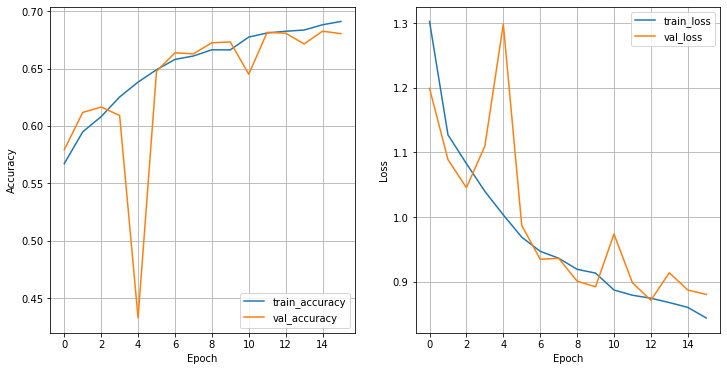

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

Note that images are labelled by humans as part of the GalaxyZoo mission. Anyone can join the website and manually label images according to the decision tree (Human in the loop). In fact, is really hard to correctly label a disc versus an in between round smooth or round smooth galaxy.

In [ ]:
#preds = tiny_model.predict(test_cat)

15/15 [==============================] - 5s 336ms/step


The result was obtained with this class distribution, a problem that I will try to overcome in the Model Selection Notebook

In [ ]:
counts = pd.DataFrame(categorical_data.groupby("LABEL").count())
counts.columns = ["count"]
counts["LABEL"] = counts.index
counts.reset_index(inplace = True, drop = True)
counts

,count,LABEL
0,1544,Cigar shaped smooth
1,6279,Disc edge on
2,32295,Elliptical
3,1344,Loose Spiral
4,5253,Medium Spiral
5,8458,Other
6,6341,Tight Spiral


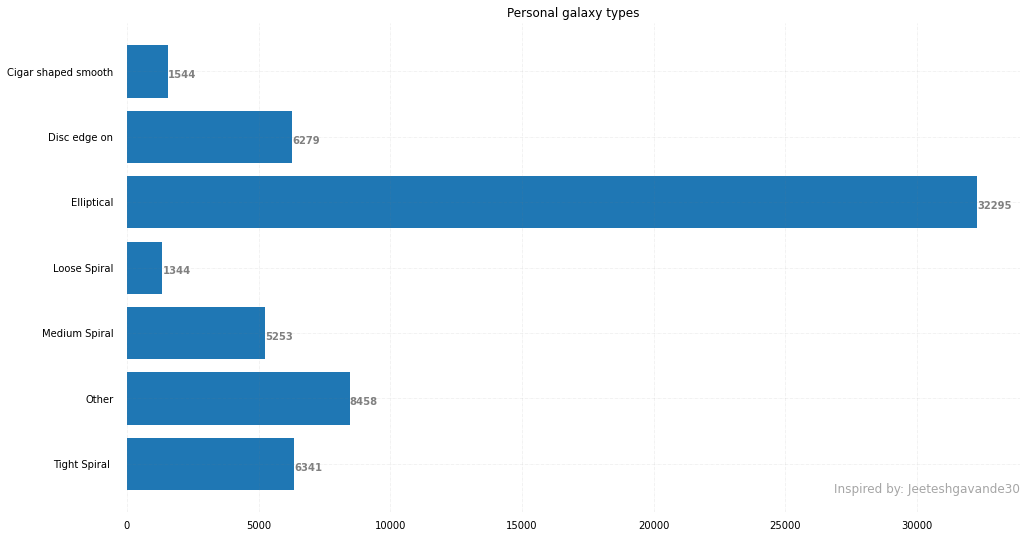

In [ ]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(counts["LABEL"], counts["count"])
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Personal galaxy types' )
 
# Add Text watermark
fig.text(0.9, 0.15, 'Inspired by: Jeeteshgavande30', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

# REGRESSION-LIKE MODEL
Since the regression model worked pretty well, let's try the same architecture for classification.

In [ ]:
with strategy.scope(): 
  image_shape = (50,50,3)
  reglike = cnn(image_shape)
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1) # Optimizer
  loss_func = tf.keras.losses.CategoricalCrossentropy() # Loss function
  reglike.compile(loss=loss_func, optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy()]) 


reglike.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        12832     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 32)  

In [ ]:
num_epochs = 25
verbose = True

# Callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

lr_scheduler = callbacks.LearningRateScheduler(decay_schedule)

early_stop = callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=10)

checkpoint = callbacks.ModelCheckpoint('best_model', save_best_only=True, monitor='val_categorical_accuracy', mode='max')   

callbacksInUse = [reduce_lr, lr_scheduler, early_stop, checkpoint]

Train the model

In [ ]:
print('------- Training -------')
start = time.time()
history = reglike.fit(train_cat, validation_data=val_cat, epochs=num_epochs, callbacks=callbacksInUse, use_multiprocessing=True, verbose=True)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/25
385/385 [==============================] - ETA: 0s - loss: 1.1326 - categorical_accuracy: 0.5930

385/385 [==============================] - 235s 605ms/step - loss: 1.1326 - categorical_accuracy: 0.5930 - val_loss: 1.1618 - val_categorical_accuracy: 0.5741 - lr: 0.1000
Epoch 2/25
385/385 [==============================] - ETA: 0s - loss: 1.0031 - categorical_accuracy: 0.6353

385/385 [==============================] - 94s 243ms/step - loss: 1.0031 - categorical_accuracy: 0.6353 - val_loss: 1.1254 - val_categorical_accuracy: 0.6247 - lr: 0.1000
Epoch 3/25
385/385 [==============================] - ETA: 0s - loss: 0.9505 - categorical_accuracy: 0.6515

385/385 [==============================] - 95s 246ms/step - loss: 0.9505 - categorical_accuracy: 0.6515 - val_loss: 1.0550 - val_categorical_accuracy: 0.6273 - lr: 0.1000
Epoch 4/25
385/385 [==============================] - ETA: 0s - loss: 0.9209 - categorical_accuracy: 0.6612

385/385 [==============================] - 94s 245ms/step - loss: 0.9209 - categorical_accuracy: 0.6612 - val_loss: 0.9548 - val_categorical_accuracy: 0.6402 - lr: 0.1000
Epoch 5/25
385/385 [==============================] - ETA: 0s - loss: 0.8890 - categorical_accuracy: 0.6740

385/385 [==============================] - 99s 258ms/step - loss: 0.8890 - categorical_accuracy: 0.6740 - val_loss: 0.8854 - val_categorical_accuracy: 0.6727 - lr: 0.0800
Epoch 6/25
385/385 [==============================] - ETA: 0s - loss: 0.8772 - categorical_accuracy: 0.6774

385/385 [==============================] - 95s 248ms/step - loss: 0.8772 - categorical_accuracy: 0.6774 - val_loss: 0.8711 - val_categorical_accuracy: 0.6736 - lr: 0.0800
Epoch 7/25
385/385 [==============================] - ETA: 0s - loss: 0.8627 - categorical_accuracy: 0.6848

385/385 [==============================] - 96s 249ms/step - loss: 0.8627 - categorical_accuracy: 0.6848 - val_loss: 0.8820 - val_categorical_accuracy: 0.6758 - lr: 0.0800
Epoch 8/25
385/385 [==============================] - 92s 239ms/step - loss: 0.8532 - categorical_accuracy: 0.6882 - val_loss: 0.8818 - val_categorical_accuracy: 0.6725 - lr: 0.0800
Epoch 9/25
385/385 [==============================] - ETA: 0s - loss: 0.8401 - categorical_accuracy: 0.6915

385/385 [==============================] - 96s 250ms/step - loss: 0.8401 - categorical_accuracy: 0.6915 - val_loss: 0.8431 - val_categorical_accuracy: 0.6851 - lr: 0.0640
Epoch 10/25
385/385 [==============================] - ETA: 0s - loss: 0.8320 - categorical_accuracy: 0.6949

385/385 [==============================] - 95s 248ms/step - loss: 0.8320 - categorical_accuracy: 0.6949 - val_loss: 0.8468 - val_categorical_accuracy: 0.6897 - lr: 0.0640
Epoch 11/25
385/385 [==============================] - 93s 240ms/step - loss: 0.8226 - categorical_accuracy: 0.6988 - val_loss: 0.8699 - val_categorical_accuracy: 0.6828 - lr: 0.0640
Epoch 12/25
385/385 [==============================] - ETA: 0s - loss: 0.8193 - categorical_accuracy: 0.6990

385/385 [==============================] - 97s 252ms/step - loss: 0.8193 - categorical_accuracy: 0.6990 - val_loss: 0.8544 - val_categorical_accuracy: 0.6914 - lr: 0.0128
Epoch 13/25
385/385 [==============================] - ETA: 0s - loss: 0.7939 - categorical_accuracy: 0.7084

385/385 [==============================] - 95s 247ms/step - loss: 0.7939 - categorical_accuracy: 0.7084 - val_loss: 0.8098 - val_categorical_accuracy: 0.7030 - lr: 0.0102
Epoch 14/25
385/385 [==============================] - ETA: 0s - loss: 0.7910 - categorical_accuracy: 0.7089

385/385 [==============================] - 96s 248ms/step - loss: 0.7910 - categorical_accuracy: 0.7089 - val_loss: 0.8029 - val_categorical_accuracy: 0.7038 - lr: 0.0102
Epoch 15/25
385/385 [==============================] - 92s 240ms/step - loss: 0.7885 - categorical_accuracy: 0.7098 - val_loss: 0.8129 - val_categorical_accuracy: 0.7008 - lr: 0.0102
Epoch 16/25
385/385 [==============================] - 92s 240ms/step - loss: 0.7861 - categorical_accuracy: 0.7106 - val_loss: 0.8183 - val_categorical_accuracy: 0.7010 - lr: 0.0102
Epoch 17/25
385/385 [==============================] - 92s 240ms/step - loss: 0.7832 - categorical_accuracy: 0.7125 - val_loss: 0.8086 - val_categorical_accuracy: 0.7016 - lr: 0.0016
Epoch 18/25
385/385 [==============================] - ETA: 0s - loss: 0.7785 - categorical_accuracy: 0.7150

385/385 [==============================] - 96s 249ms/step - loss: 0.7785 - categorical_accuracy: 0.7150 - val_loss: 0.8058 - val_categorical_accuracy: 0.7050 - lr: 0.0016
Epoch 19/25
385/385 [==============================] - ETA: 0s - loss: 0.7766 - categorical_accuracy: 0.7155

385/385 [==============================] - 98s 255ms/step - loss: 0.7766 - categorical_accuracy: 0.7155 - val_loss: 0.8085 - val_categorical_accuracy: 0.7054 - lr: 0.0016
Epoch 20/25
385/385 [==============================] - 92s 239ms/step - loss: 0.7768 - categorical_accuracy: 0.7129 - val_loss: 0.8067 - val_categorical_accuracy: 0.7052 - lr: 3.2768e-04
Epoch 21/25
385/385 [==============================] - 92s 240ms/step - loss: 0.7782 - categorical_accuracy: 0.7139 - val_loss: 0.8102 - val_categorical_accuracy: 0.7049 - lr: 2.6214e-04
Epoch 22/25
385/385 [==============================] - ETA: 0s - loss: 0.7777 - categorical_accuracy: 0.7143

385/385 [==============================] - 96s 250ms/step - loss: 0.7777 - categorical_accuracy: 0.7143 - val_loss: 0.8098 - val_categorical_accuracy: 0.7055 - lr: 2.6214e-04
Epoch 23/25
385/385 [==============================] - 93s 241ms/step - loss: 0.7773 - categorical_accuracy: 0.7147 - val_loss: 0.8088 - val_categorical_accuracy: 0.7055 - lr: 5.2429e-05
Epoch 24/25
385/385 [==============================] - ETA: 0s - loss: 0.7801 - categorical_accuracy: 0.7115

385/385 [==============================] - 97s 252ms/step - loss: 0.7801 - categorical_accuracy: 0.7115 - val_loss: 0.8089 - val_categorical_accuracy: 0.7057 - lr: 5.2429e-05
Epoch 24: early stopping
Total training took 0.85 hours.


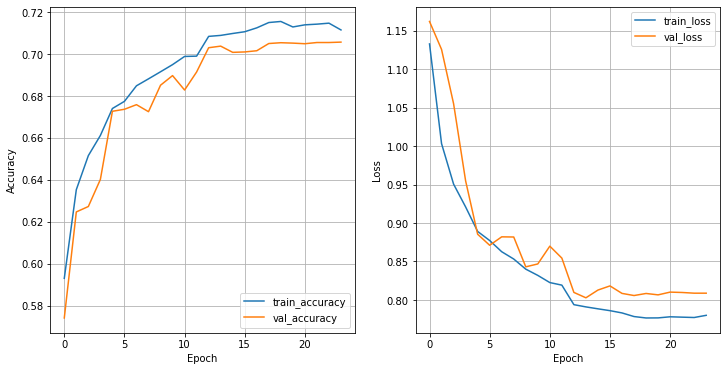

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
#test the model

results = reglike.evaluate(test_cat, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

15/15 [==============================] - 19s 1s/step - loss: 0.7937 - categorical_accuracy: 0.7046
Test accuracy: 0.705
